# Introducción al Procesamiento de Lenguage Natural

En este notebook exploramos conceptos fundamentales del procesamiento de lenguaje natural (PLN), como la representación vectorial de palabras y la generación de texto secuencial. Comenzamos entrenando un modelo simple basado en el enfoque CBOW (Continuous Bag of Words) para aprender embeddings semánticos de palabras, los cuales visualizamos en dos dimensiones para analizar sus relaciones. A continuación, entrenamos dos modelos de redes neuronales recurrentes (RNN): uno que utiliza embeddings aprendidos previamente por CBOW y otro que aprende sus propias representaciones desde cero. Finalmente, comparamos la calidad del texto generado por ambos modelos.

## Parte 1: Representación Vectorial de Palabras Usando CBOW

El modelo **CBOW (Continuous Bag of Words)** es una arquitectura de red neuronal utilizada para aprender **representaciones vectoriales densas** de palabras (embeddings). Su objetivo es **predecir una palabra central dada su ventana de contexto**, utilizando un corpus de texto.<br><br><br>

Se trata de un problema de **clasificación multiclase**, donde se intenta predecir la palabra objetivo a partir de las palabras vecinas (contexto).<br><br><br>

Dado un conjunto de palabras de contexto $C = \{ w_{t - c}, \ldots, w_{t - 1}, w_{t + 1}, \ldots, w_{t + c} \}$, queremos predecir la palabra central $w_t$:

$$
\hat{y} = \arg\max_{w \in V} \; P(w \mid C)
$$

El modelo se entrena para **maximizar la similitud** (producto punto) entre el vector promedio del contexto y el vector de salida de la palabra correcta, usando softmax:

$$
P(w_t \mid C) = \frac{\exp(\mathbf{u}_{w_t}^\top \bar{\mathbf{v}}_C)}{\sum_{w \in V} \exp(\mathbf{u}_w^\top \bar{\mathbf{v}}_C)}
$$

donde:

- $\bar{\mathbf{v}}_C = \frac{1}{2c} \sum_{w_i \in C} \mathbf{v}_{w_i}$ es el promedio de embeddings de las palabras de contexto,
- $\mathbf{v}_{w_i}$ es el embedding de entrada de la palabra $w_i$,
- $\mathbf{u}_{w}$ es el embedding de salida de la palabra $w$,
- $V$es el vocabulario completo.
<br><br><br>
El entrenamiento se realiza minimizando la **entropía cruzada** entre la distribución predicha y la verdadera.

In [1]:
# Importamos librerías necesarias

import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [2]:
# Reproducibilidad casi completa (no funciona para tarjetas gráficas exóticas)

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# Corpus pequeño para el ejemplo

# corpus = [
#     "el gato duerme en el sofá",
#     "el perro corre en el parque",
#     "la gata se esconde bajo la cama",
#     "el niño juega con el perro",
#     "la niña duerme en la silla"
# ]

corpus = [
    "el gato se sentó en el tapete",
    "el perro se acostó en el sofá",
    "la gata se sentó en la silla"
]

oraciones = [oracion.lower().split() for oracion in corpus] # Separamos las frases en palabras individuales
pre_vocabulario = [palabra for oracion in oraciones for palabra in oracion]
vocabulario = sorted(set(pre_vocabulario)) # Palabras únicas en orden alfabético
tam_vocabulario = len(vocabulario)
print(f'\n El vocabulario consiste de las siguientes palabras:{vocabulario} \n Son en total {tam_vocabulario} palabras')




 El vocabulario consiste de las siguientes palabras:['acostó', 'el', 'en', 'gata', 'gato', 'la', 'perro', 'se', 'sentó', 'silla', 'sofá', 'tapete'] 
 Son en total 12 palabras


In [4]:
palabra_a_indice = {palabra: i for i, palabra in enumerate(vocabulario)}
palabra_a_indice

{'acostó': 0,
 'el': 1,
 'en': 2,
 'gata': 3,
 'gato': 4,
 'la': 5,
 'perro': 6,
 'se': 7,
 'sentó': 8,
 'silla': 9,
 'sofá': 10,
 'tapete': 11}

In [5]:
class ModeloCBOW(nn.Module):
    """
    Modelo CBOW: predice la palabra objetivo a partir del contexto.

    Atributos:
        embeddings (nn.Embedding): capa de embeddings que aprende representaciones de palabras
        proyector (nn.Linear): capa de salida que proyecta al espacio del vocabulario
    """
    def __init__(self, tam_vocabulario, dim_embedding):
        """
        Inicializa el modelo CBOW.

        Parámetros:
            tam_vocabulario (int): tamaño del vocabulario
            dim_embedding (int): dimensión del vector de embedding
        """
        super().__init__()
        self.embeddings = nn.Embedding(tam_vocabulario, dim_embedding)
        self.proyector = nn.Linear(dim_embedding, tam_vocabulario)

    def forward(self, indices_contexto):
        """
        Calcula la predicción de la palabra central a partir del contexto.

        Parámetros:
            indices_contexto (Tensor): índices de palabras de contexto (LongTensor)

        Retorna:
            logits (Tensor): puntuaciones (sin softmax) para cada palabra del vocabulario
        """
        emb = self.embeddings(indices_contexto)       # Índices en vez de vectores dispersos
        promedio = emb.mean(dim=0)                    # Vector promedio del contexto
        logits = self.proyector(promedio)             # Salida sin aplicar softmax
        return logits

In [6]:

def construir_datos_cbow(oraciones, palabra_a_indice, tam_contexto=1):
    """
    Construye pares (contexto, objetivo) para el entrenamiento CBOW.
    
    Parámetros:
        oraciones (list): lista de listas de palabras (corpus tokenizado)
        palabra_a_indice (dict): dicionario con palabras e indices
        tam_contexto (int): número de palabras antes y después del centro
    
    Retorna:
        lista de tuplas (tensor_contexto, tensor_objetivo)
    """
    datos = []
    for oracion in oraciones:
        for i in range(tam_contexto, len(oracion) - tam_contexto):
            contexto = [oracion[i - j - 1] for j in range(tam_contexto)] + \
                       [oracion[i + j + 1] for j in range(tam_contexto)]
            objetivo = oracion[i]
            datos.append((
                torch.tensor([palabra_a_indice[p] for p in contexto], dtype=torch.long),
                torch.tensor(palabra_a_indice[objetivo], dtype=torch.long)
            ))
    return datos

datos = construir_datos_cbow(oraciones, palabra_a_indice)
datos

[(tensor([1, 7]), tensor(4)),
 (tensor([4, 8]), tensor(7)),
 (tensor([7, 2]), tensor(8)),
 (tensor([8, 1]), tensor(2)),
 (tensor([ 2, 11]), tensor(1)),
 (tensor([1, 7]), tensor(6)),
 (tensor([6, 0]), tensor(7)),
 (tensor([7, 2]), tensor(0)),
 (tensor([0, 1]), tensor(2)),
 (tensor([ 2, 10]), tensor(1)),
 (tensor([5, 7]), tensor(3)),
 (tensor([3, 8]), tensor(7)),
 (tensor([7, 2]), tensor(8)),
 (tensor([8, 5]), tensor(2)),
 (tensor([2, 9]), tensor(5))]

In [7]:
print(vocabulario[1], vocabulario[4], vocabulario[7]) # Ejemplo para entender qué es el contexto

el gato se


In [8]:
# Definición y entrenamiento del modelo

dim_embedding = 2
modelo_CBOW = ModeloCBOW(tam_vocabulario, dim_embedding)
optimizador = optim.Adam(modelo_CBOW.parameters(), lr=0.01)
criterio = nn.CrossEntropyLoss()

for epoca in range(1001):
    perdida_total = 0
    for contexto, objetivo in datos:
        modelo_CBOW.zero_grad()
        salida = modelo_CBOW(contexto)
        perdida = criterio(salida.unsqueeze(0), objetivo.unsqueeze(0))
        perdida.backward()
        optimizador.step()
        perdida_total += perdida.item()
    if epoca % 100 == 0:
        print(f"Época {epoca}, pérdida: {perdida_total:.4f}")

Época 0, pérdida: 36.6435
Época 100, pérdida: 5.9230
Época 200, pérdida: 3.8861
Época 300, pérdida: 3.5870
Época 400, pérdida: 3.4975
Época 500, pérdida: 3.4610
Época 600, pérdida: 3.4413
Época 700, pérdida: 3.4281
Época 800, pérdida: 3.4178
Época 900, pérdida: 3.4088
Época 1000, pérdida: 3.4006


In [9]:
# Ejemplo de uso unsqueeze
a = torch.tensor([1, 2, 3, 4])  

a.unsqueeze(0) 

tensor([[1, 2, 3, 4]])

In [10]:
# Generamos la representación vectorial de cada palabra

def obtener_embedding(modelo, palabra, palabra_a_indice):
    indice = palabra_a_indice[palabra]
    embedding = modelo.embeddings.weight[indice]
    return embedding    

In [11]:
v_gato = obtener_embedding(modelo_CBOW, 'gato', palabra_a_indice)
print(f'El vector que representa a gato es: {v_gato}')

El vector que representa a gato es: tensor([4.0834, 8.0384], grad_fn=<SelectBackward0>)


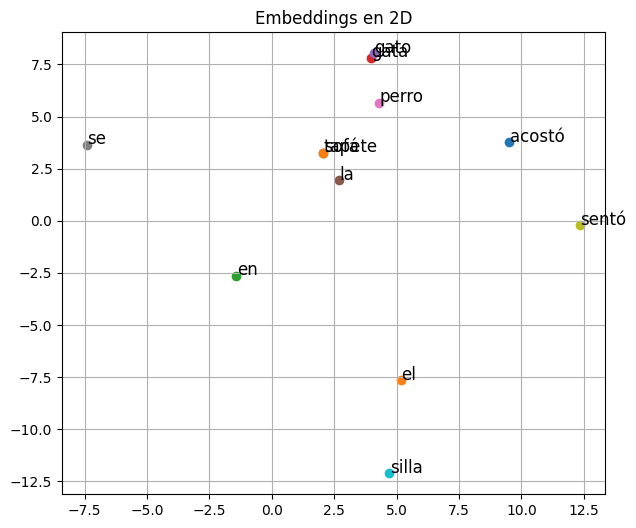

In [12]:
# Asumimos que dim_embedding = 2
vectores = modelo_CBOW.embeddings.weight.detach().numpy()

plt.figure(figsize=(7, 6))
for i, palabra in enumerate(vocabulario):
    x, y = vectores[i]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, palabra, fontsize=12)

plt.title("Embeddings en 2D")
plt.grid(True)
plt.show()


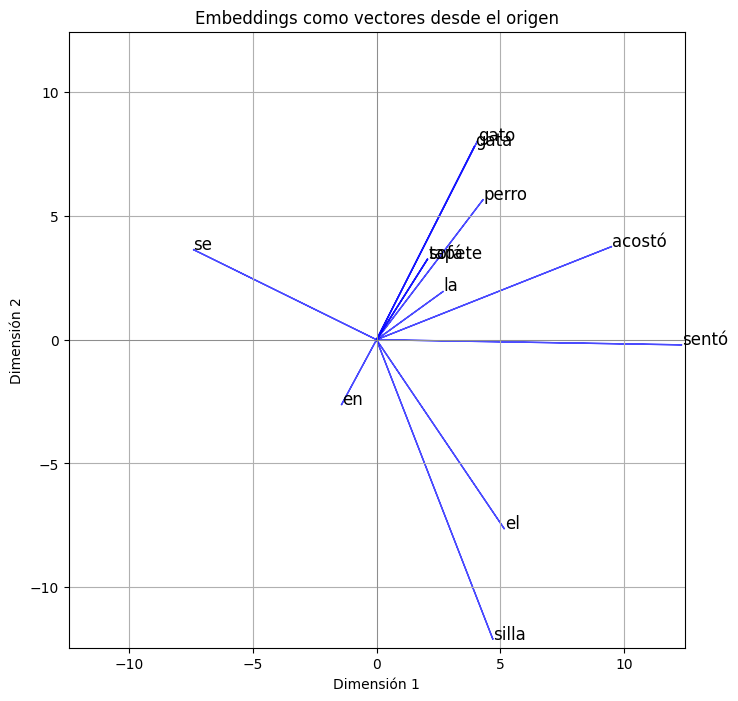

In [13]:
# Obtener los embeddings (dimensión 2 esperada)
vectores = modelo_CBOW.embeddings.weight.detach().cpu().numpy()

# Ajustar rango dinámico para visualización
max_val = np.abs(vectores).max() + 0.1

# Crear figura
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Dibujar cada vector como flecha desde el origen
for i, palabra in enumerate(vocabulario):
    x, y = vectores[i]
    ax.arrow(0, 0, x, y, head_width=0.02, head_length=0.03, fc='blue', ec='blue', alpha=0.7, length_includes_head=True)
    plt.text(x + 0.015, y + 0.015, palabra, fontsize=12)

# Ajustes de visualización
plt.xlim(-max_val, max_val)
plt.ylim(-max_val, max_val)
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.title("Embeddings como vectores desde el origen")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()


In [14]:
vectores = torch.stack([obtener_embedding(modelo_CBOW, p, palabra_a_indice) for p in vocabulario]).cpu().detach().numpy()
vectores

array([[  9.51405   ,   3.7698107 ],
       [  5.171762  ,  -7.653797  ],
       [ -1.4245999 ,  -2.6399357 ],
       [  3.9609988 ,   7.8268523 ],
       [  4.083428  ,   8.03844   ],
       [  2.7055492 ,   1.9594485 ],
       [  4.3141694 ,   5.673663  ],
       [ -7.4110866 ,   3.6478674 ],
       [ 12.348579  ,  -0.20727865],
       [  4.707514  , -12.116917  ],
       [  2.0690243 ,   3.2712917 ],
       [  2.0709085 ,   3.2712066 ]], dtype=float32)

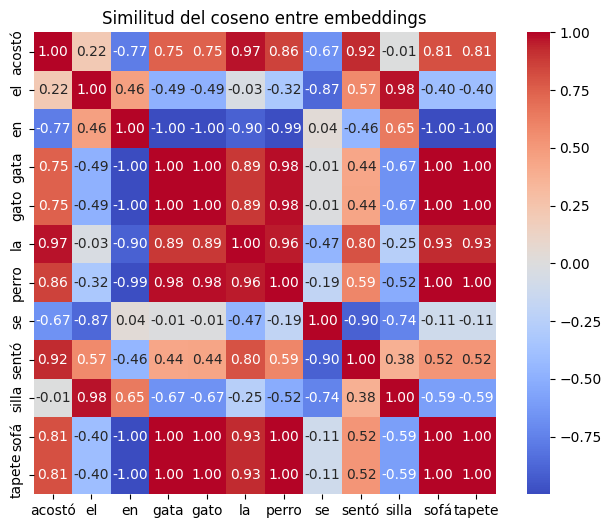

In [15]:
# Calculamos similitud

matriz_sim = cosine_similarity(vectores)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_sim, xticklabels=vocabulario, yticklabels=vocabulario, annot=True, cmap="coolwarm", square=True, fmt=".2f")
plt.title("Similitud del coseno entre embeddings")
plt.show()

## Parte 2: Generación de Texto con Redes Neuronales Recurrentes


Una **Red Neuronal Recurrente (RNN)** es un tipo de arquitectura diseñada para procesar **secuencias de datos**, donde la información de pasos anteriores influye en el procesamiento del paso actual. Es especialmente útil en tareas de **modelado de lenguaje**, donde el orden de las palabras importa.
<br><br><br>

A diferencia de modelos como CBOW, que ignoran el orden del contexto, las RNNs modelan explícitamente la **dependencia temporal** entre las palabras.
<br><br><br>

**Modelado de Lenguaje con RNN**

En el modelado de lenguaje, el objetivo es predecir la siguiente palabra dada una secuencia de palabras anteriores. Esto se puede expresar como:

$$
P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^T P(w_t \mid w_1, \ldots, w_{t-1})
$$

El modelo RNN procesa secuencialmente las palabras, actualizando un **estado oculto** $h_t$ en cada paso:

$$
h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$

donde:

- $x_t$ es el vector de embedding de la palabra en el paso $t$,
- $h_{t-1}$ es el estado oculto anterior,
- $W_{xh}$ y $W_{hh}$ son matrices de pesos aprendibles,
- $b_h$ es el sesgo,
- $\tanh$ es la función de activación no lineal.

<br><br><br>

**Predicción y Entrenamiento**

A partir del estado oculto $h_t$, se predice la próxima palabra mediante una capa de salida con softmax:

$$
P(w_{t+1} \mid w_{\leq t}) = \text{softmax}(W_{hy} \cdot h_t + b_y)
$$

El modelo se entrena minimizando la **entropía cruzada** entre la distribución predicha y la palabra verdadera siguiente.
<br><br><br>

Limitaciones de las RNNs clásicas

- **Gradientes que se desvanecen o explotan**, lo cual dificulta aprender dependencias a largo plazo.
- Procesamiento **secuencial no paralelizable**.
- Dificultad para modelar estructuras gramaticales complejas a largo plazo.

<br><br><br>
Estas limitaciones motivaron el desarrollo de variantes como **LSTMs** y **GRUs**, y eventualmente de arquitecturas más potentes como los **Transformers**, que permiten capturar relaciones de largo alcance usando mecanismos de atención.



In [16]:
import torch.nn.functional as F

In [17]:
corpus = [
    "el gato duerme en el sofá",
    "el perro corre en el parque",
    "la gata se esconde bajo la cama",
    "el niño juega con el perro",
    "la niña duerme en la silla"
]

oraciones_2 = [frase.lower().split() for frase in corpus]
pre_vocabulario_2 = [palabra for oracion in oraciones_2 for palabra in oracion]
vocabulario_2 = sorted(set(pre_vocabulario_2))
tam_vocabulario_2 = len(vocabulario_2)

palabra_a_indice_2 = {p: i for i, p in enumerate(vocabulario_2)}
indice_a_palabra_2 = {i: p for p, i in palabra_a_indice_2.items()}

datos_2 = construir_datos_cbow(oraciones_2, palabra_a_indice_2, 1)
datos_2

[(tensor([5, 4]), tensor(9)),
 (tensor([9, 6]), tensor(4)),
 (tensor([4, 5]), tensor(6)),
 (tensor([ 6, 18]), tensor(5)),
 (tensor([5, 3]), tensor(15)),
 (tensor([15,  6]), tensor(3)),
 (tensor([3, 5]), tensor(6)),
 (tensor([ 6, 14]), tensor(5)),
 (tensor([11, 16]), tensor(8)),
 (tensor([8, 7]), tensor(16)),
 (tensor([16,  0]), tensor(7)),
 (tensor([ 7, 11]), tensor(0)),
 (tensor([0, 1]), tensor(11)),
 (tensor([ 5, 10]), tensor(13)),
 (tensor([13,  2]), tensor(10)),
 (tensor([10,  5]), tensor(2)),
 (tensor([ 2, 15]), tensor(5)),
 (tensor([11,  4]), tensor(12)),
 (tensor([12,  6]), tensor(4)),
 (tensor([ 4, 11]), tensor(6)),
 (tensor([ 6, 17]), tensor(11))]

In [18]:
dim_embedding = 2
modelo_cbow_2 = ModeloCBOW(tam_vocabulario_2, dim_embedding)
optimizador = optim.Adam(modelo_cbow_2.parameters(), lr=0.01)
criterio = nn.CrossEntropyLoss()

for epoca in range(1001):
    perdida_total = 0
    for contexto, objetivo in datos_2:
        modelo_cbow_2.zero_grad()
        salida = modelo_cbow_2(contexto)
        perdida = criterio(salida.unsqueeze(0), objetivo.unsqueeze(0))
        perdida.backward()
        optimizador.step()
        perdida_total += perdida.item()
    if epoca % 100 == 0:
        print(f"Época {epoca}, pérdida: {perdida_total:.4f}")

Época 0, pérdida: 70.3254
Época 100, pérdida: 15.2674
Época 200, pérdida: 9.0586
Época 300, pérdida: 7.2020
Época 400, pérdida: 6.3555
Época 500, pérdida: 6.0388
Época 600, pérdida: 5.9075
Época 700, pérdida: 5.8436
Época 800, pérdida: 5.8117
Época 900, pérdida: 5.7948
Época 1000, pérdida: 5.7843


In [19]:
def construir_pares(oraciones, palabra_a_ix):
    """
    Genera pares (entrada, objetivo) a partir de una lista de oraciones tokenizadas.

    Cada par corresponde a una palabra y su siguiente palabra en la oración,
    útil para tareas de modelado secuencial como entrenamiento de RNNs generativas.

    Parámetros:
        oraciones (list): Lista de oraciones, cada una como lista de palabras (tokens).
        palabra_a_ix (dict): Diccionario que mapea cada palabra a un índice entero.

    Retorna:
        list: Lista de tuplas (índice_palabra_t, índice_palabra_t+1)
    """
    pares = []
    for oracion in oraciones:
        for i in range(len(oracion) - 1):
            entrada = palabra_a_ix[oracion[i]]
            objetivo = palabra_a_ix[oracion[i+1]]
            pares.append((entrada, objetivo))
    return pares

datos_rnn = construir_pares(oraciones_2, palabra_a_indice_2)

In [20]:
class RNNGeneradora(nn.Module):
    """
    Red neuronal recurrente (RNN) para generación de texto palabra por palabra.

    Esta clase recibe una capa de embeddings (preentrenada o nueva), procesa
    secuencias de entrada mediante una RNN y genera logits sobre el vocabulario
    en cada paso de tiempo.

    Atributos:
        embedding (nn.Embedding): capa de embeddings para convertir índices en vectores.
        rnn (nn.RNN): capa recurrente para procesar la secuencia.
        fc (nn.Linear): capa lineal para proyectar el estado oculto al espacio del vocabulario.
    """
    def __init__(self, embedding_layer, hidden_size, vocab_size):
        """
        Inicializa la RNNGeneradora.

        Parámetros:
            embedding_layer (nn.Embedding): Capa de embeddings (puede ser preentrenada o nueva).
            hidden_size (int): Tamaño del estado oculto de la RNN.
            vocab_size (int): Tamaño del vocabulario (salida de la capa final).
        """
        super().__init__()
        self.embedding = embedding_layer
        self.rnn = nn.RNN(embedding_layer.embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
        Ejecuta la pasada hacia adelante de la red.

        Parámetros:
            x (Tensor): Secuencia de índices de palabras (batch_size x secuencia).
            hidden (Tensor, opcional): Estado oculto inicial de la RNN.

        Retorna:
            logits (Tensor): Salidas sin normalizar para cada palabra del vocabulario.
            hidden (Tensor): Estado oculto actualizado de la RNN.
        """
        emb = self.embedding(x)
        salida, hidden = self.rnn(emb, hidden)
        logits = self.fc(salida)
        return logits, hidden

In [21]:
embedding_cbow = nn.Embedding(tam_vocabulario_2, dim_embedding)
embedding_cbow.weight.data.copy_(modelo_cbow_2.embeddings.weight.data)
embedding_cbow.weight.requires_grad = False
modelo_rnn_cbow = RNNGeneradora(embedding_cbow, hidden_size=32, vocab_size=tam_vocabulario_2)

embedding_nuevo = nn.Embedding(tam_vocabulario_2, dim_embedding)
modelo_rnn_nuevo = RNNGeneradora(embedding_nuevo, hidden_size=32, vocab_size=tam_vocabulario_2)

In [22]:
epocas = 1001
def entrenar(modelo, datos, epochs=60):
    """
    Entrena un modelo de lenguaje (por ejemplo, una RNN) con pares de datos entrada-objetivo.

    Parámetros:
        modelo (nn.Module): Modelo a entrenar.
        datos (list): Lista de tuplas (entrada, objetivo) representando índices de palabras.
        epochs (int): Número de épocas de entrenamiento.
    """
    opt = torch.optim.Adam(modelo.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for entrada, objetivo in datos:
            x = torch.tensor([entrada]).unsqueeze(0)  
            y = torch.tensor([objetivo]).unsqueeze(0)  
            out, _ = modelo(x)
            loss = loss_fn(out.squeeze(1), y.squeeze(1))
            opt.zero_grad()
            loss.backward()
            opt.step()

entrenar(modelo_rnn_cbow, datos_rnn)
entrenar(modelo_rnn_nuevo, datos_rnn)

In [23]:
def generar_texto(modelo, ix_a_palabra, palabra_a_ix, inicio="el", max_long=8):
    """
    Genera una secuencia de texto a partir de una palabra inicial usando un modelo entrenado.

    En cada paso, el modelo predice la siguiente palabra basándose en la entrada anterior,
    seleccionándola mediante muestreo aleatorio según la distribución de probabilidad (softmax).

    Parámetros:
        modelo (nn.Module): Modelo de lenguaje entrenado (como una RNN).
        ix_a_palabra (dict): Diccionario que mapea índices a palabras.
        palabra_a_ix (dict): Diccionario que mapea palabras a índices.
        inicio (str): Palabra inicial para comenzar la generación.
        max_long (int): Longitud máxima de la secuencia generada.

    Retorna:
        str: Secuencia de palabras generada como una cadena.
    """
    modelo.eval()
    palabras = [inicio]
    input_tensor = torch.tensor([[palabra_a_ix[inicio]]])
    hidden = None
    for _ in range(max_long):
        with torch.no_grad():
            salida, hidden = modelo(input_tensor, hidden)
            probs = F.softmax(salida[0, -1], dim=0)
            pred_idx = torch.multinomial(probs, 1).item()
            palabra_pred = ix_a_palabra[pred_idx]
            palabras.append(palabra_pred)
            input_tensor = torch.tensor([[pred_idx]])
    return ' '.join(palabras)

In [24]:
print("\n Texto generado con embeddings de CBOW:")
print(generar_texto(modelo_rnn_cbow, indice_a_palabra_2, palabra_a_indice_2, inicio="el"))

print("\n Texto generado con embedding nuevo:")
print(generar_texto(modelo_rnn_nuevo, indice_a_palabra_2, palabra_a_indice_2, inicio="el"))


 Texto generado con embeddings de CBOW:
el niño juega con el sofá la gata se

 Texto generado con embedding nuevo:
el gato duerme en el niño juega con el
